# **Load Data**

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("hashbanger/ph2-resized")

print("Path to dataset files:", path)

100%|██████████| 47.9M/47.9M [00:00<00:00, 110MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/hashbanger/ph2-resized/versions/1


In [2]:
from keras.models import Model, Sequential
from keras.layers import Activation, Dense, BatchNormalization, Dropout, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Input, Reshape
from keras.callbacks import EarlyStopping
from keras import backend as K
from keras.optimizers import Adam, SGD
import tensorflow as tf
import numpy as np
import pandas as pd
import glob
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from warnings import filterwarnings

filterwarnings('ignore')
plt.rcParams["axes.grid"] = False
np.random.seed(101)

In [3]:
import re
import os # Import os module for path operations
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

# Construct the correct path using the 'path' variable from kagglehub download
dataset_base_path = path

filelist_trainx = sorted(glob.glob(os.path.join(dataset_base_path, 'trainx', '*.bmp')), key=numericalSort)
X_train = np.array([np.array(Image.open(fname)) for fname in filelist_trainx])

filelist_trainy = sorted(glob.glob(os.path.join(dataset_base_path, 'trainy', '*.bmp')), key=numericalSort)
Y_train = np.array([np.array(Image.open(fname)) for fname in filelist_trainy])

print(f"Number of training images (X_train): {len(filelist_trainx)}")
print(f"Number of training masks (Y_train): {len(filelist_trainy)}")

print(f"X_train shape: {X_train.shape}")
print(f"Y_train shape: {Y_train.shape}")


Number of training images (X_train): 200
Number of training masks (Y_train): 200
X_train shape: (200, 192, 256, 3)
Y_train shape: (200, 192, 256)


In [4]:
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size = 0.25, random_state = 101)

# **visualize Data**

### Pixel Intensity Distribution

Let's visualize the pixel intensity distribution for a random training image across its RGB channels. This can give us an idea of the brightness, contrast, and color balance of the images in the dataset.

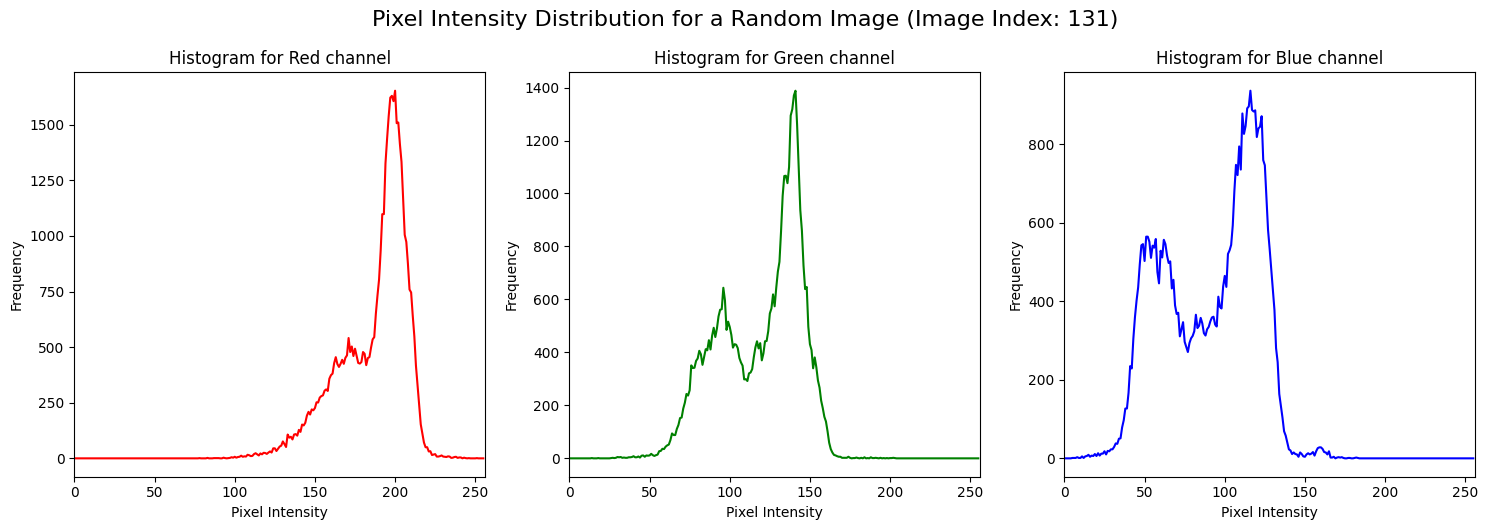

In [5]:
import random

# Select a random image from the training set
random_image_index = random.randint(0, len(x_train) - 1)
random_image = x_train[random_image_index]

plt.figure(figsize=(15, 5))

colors = ('r','g','b')
channel_names = ('Red channel','Green channel','Blue channel')

for i, (color, channel_name) in enumerate(zip(colors, channel_names)):
    plt.subplot(1, 3, i + 1)
    hist = cv2.calcHist([random_image], [i], None, [256], [0, 256])
    plt.plot(hist, color=color)
    plt.xlim([0, 256])
    plt.title(f'Histogram for {channel_name}')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.suptitle(f'Pixel Intensity Distribution for a Random Image (Image Index: {random_image_index})', y=1.05, fontsize=16)
plt.show()

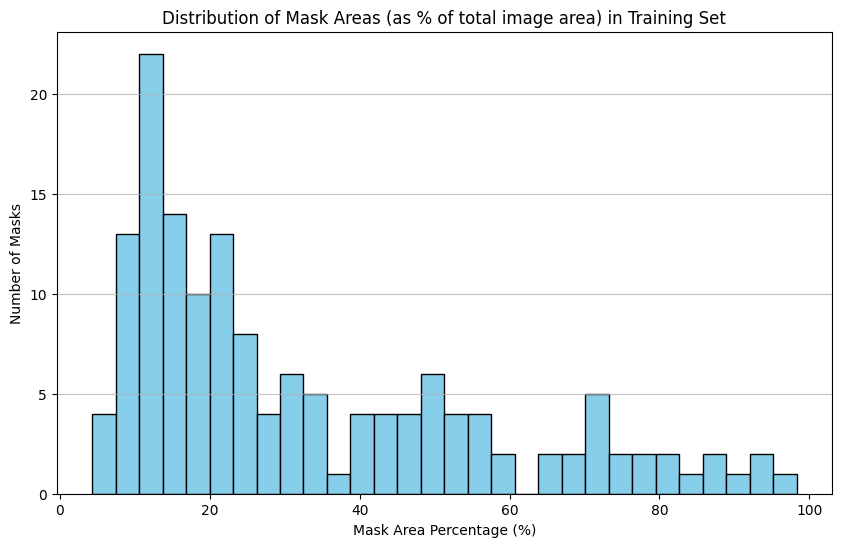

Minimum mask area percentage: 4.30%
Maximum mask area percentage: 98.31%
Average mask area percentage: 32.57%
Median mask area percentage: 22.97%


In [6]:
# Calculate the area of each mask (number of True pixels)
mask_areas = np.sum(y_train > 0, axis=(1, 2))

# Calculate the total area of an image
image_total_pixels = y_train.shape[1] * y_train.shape[2]

# Calculate mask area as a percentage of total image area
mask_area_percentages = (mask_areas / image_total_pixels) * 100

plt.figure(figsize=(10, 6))
plt.hist(mask_area_percentages, bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Mask Areas (as % of total image area) in Training Set')
plt.xlabel('Mask Area Percentage (%)')
plt.ylabel('Number of Masks')
plt.grid(axis='y', alpha=0.75)
plt.show()

print(f"Minimum mask area percentage: {np.min(mask_area_percentages):.2f}%")
print(f"Maximum mask area percentage: {np.max(mask_area_percentages):.2f}%")
print(f"Average mask area percentage: {np.mean(mask_area_percentages):.2f}%")
print(f"Median mask area percentage: {np.median(mask_area_percentages):.2f}%")

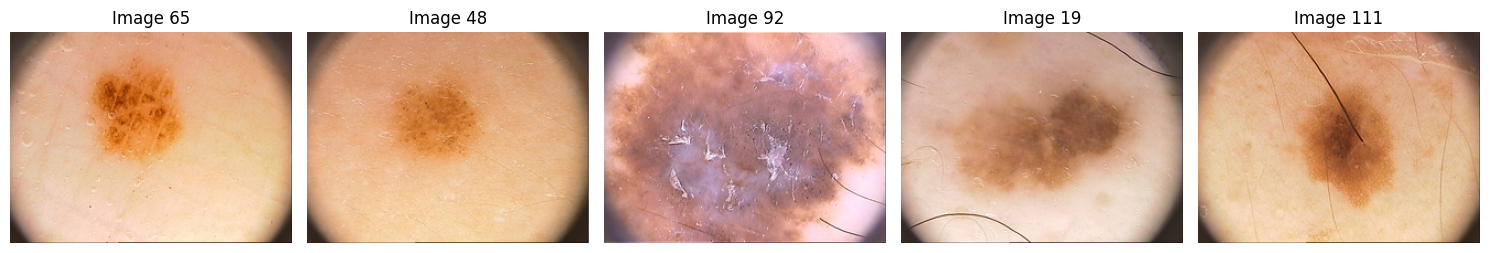

In [7]:
plt.figure(figsize=(15, 6))
for i in range(5):
    # Select a random image from the training set
    random_image_index = random.randint(0, len(x_train) - 1)
    random_image = x_train[random_image_index]

    plt.subplot(1, 5, i + 1)
    plt.imshow(random_image)
    plt.title(f'Image {random_image_index}')
    plt.axis('off')

plt.tight_layout()
plt.show()

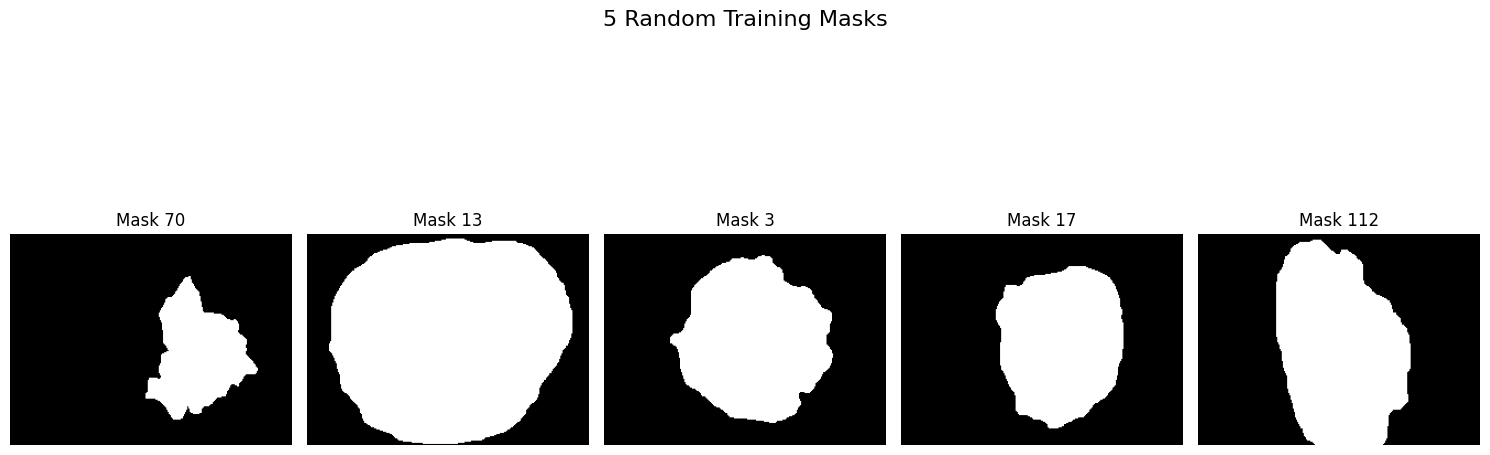

In [8]:
plt.figure(figsize=(15, 6))
for i in range(5):
    # Select a random mask from the training set
    random_mask_index = random.randint(0, len(y_train) - 1)
    random_mask = y_train[random_mask_index]

    plt.subplot(1, 5, i + 1)
    plt.imshow(random_mask, cmap='gray') # Masks are typically grayscale
    plt.title(f'Mask {random_mask_index}')
    plt.axis('off')

plt.tight_layout()
plt.suptitle('5 Random Training Masks', y=1.05, fontsize=16)
plt.show()

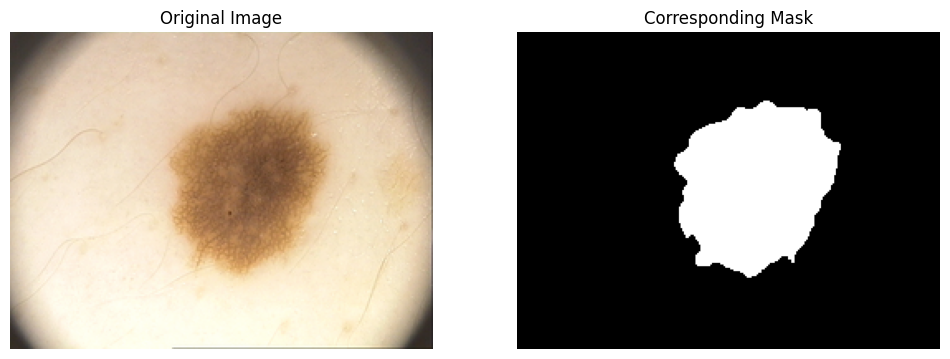

In [9]:
import random

# Select a random index
index = random.randint(0, len(x_train) - 1)

# Get the image and mask
image = x_train[index]
mask = y_train[index]

# Display the image and mask
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray') # Masks are typically grayscale
plt.title('Corresponding Mask')
plt.axis('off')

plt.show()

## Define U-Net Architecture

### Subtask:
Generate the Python code to define the U-Net model architecture using Keras/TensorFlow layers, including the encoder, bottleneck, decoder, and skip connections.


**Reasoning**:
To define the U-Net model architecture, I will create a Python code block. This block will contain the `unet_model` function, which constructs the U-Net with its encoder, bottleneck, decoder, and skip connections using Keras/TensorFlow layers. Finally, I will instantiate this model and assign it to the variable `unet` and print its summary to verify the architecture.



**✅ Key idea**

U-Net uses skip connections between encoder and decoder layers.
These connections pass fine spatial details directly to the decoder.

**✅ Architecture**

* Encoder (downsampling)

* Decoder (upsampling)

* Skip connections (concatenate feature maps)

* Fully convolutional

**✅ Strengths**

* Excellent boundary precision

* Works very well with small datasets

* Industry standard for medical segmentation

* Recovers fine details (tumor edges, lesions, etc.)

**❌ Weaknesses**

* Uses more GPU memory (because of concatenation)

* Slightly heavier model

In [10]:
from keras.layers import concatenate # Add concatenate to imports

def conv_block(input_tensor, num_filters):
    encoder = Conv2D(num_filters, (3, 3), padding='same')(input_tensor)
    encoder = BatchNormalization()(encoder)
    encoder = Activation('relu')(encoder)
    encoder = Conv2D(num_filters, (3, 3), padding='same')(encoder)
    encoder = BatchNormalization()(encoder)
    encoder = Activation('relu')(encoder)
    return encoder

def unet_model(input_size=(192, 256, 3)):
    inputs = Input(input_size)

    # Encoder
    conv1 = conv_block(inputs, 64)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = conv_block(pool1, 128)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = conv_block(pool2, 256)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = conv_block(pool3, 512)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    # Bottleneck
    conv5 = conv_block(pool4, 1024)

    # Decoder
    up6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(conv5)
    up6 = concatenate([up6, conv4], axis=3)
    conv6 = conv_block(up6, 512)

    up7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv6)
    up7 = concatenate([up7, conv3], axis=3)
    conv7 = conv_block(up7, 256)

    up8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv7)
    up8 = concatenate([up8, conv2], axis=3)
    conv8 = conv_block(up8, 128)

    up9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8)
    up9 = concatenate([up9, conv1], axis=3)
    conv9 = conv_block(up9, 64)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model

# Instantiate the model
unet = unet_model()
unet.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 192, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 192, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 192, 256,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 192, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 192, 256,  │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 192, 256,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 192, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 96, 128,   │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 96, 128,   │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 96, 128,   │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 96, 128,   │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 96, 128,   │    147,584 │ activation_2[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 96, 128,   │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 96, 128,   │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 48, 64,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 48, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 48, 64,    │      1,024 │ conv2d_4[0][0]  

 Total params: 31,055,297 (118.47 MB)

 Trainable params: 31,043,521 (118.42 MB)

 Non-trainable params: 11,776 (46.00 KB)

## Compile U-Net Model

### Subtask:
Compile the defined U-Net model with a suitable optimizer, loss function, and metrics for image segmentation.


**Reasoning**:
The user wants to compile the U-Net model with specific parameters: Adam optimizer with a learning rate of 1e-4, 'binary_crossentropy' as the loss function, and 'accuracy' as a metric. This can be achieved by calling the `.compile()` method on the `unet` model.



In [11]:
unet.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
print("U-Net model compiled successfully with Adam optimizer, binary crossentropy loss, and accuracy metric.")

U-Net model compiled successfully with Adam optimizer, binary crossentropy loss, and accuracy metric.


# Task
Prepare `y_train` and `y_test` by converting them to `float32` data type and expanding their dimensions to `(num_samples, height, width, 1)`. Then, train the `unet` model using `x_train`, `y_train` as training data and `x_test`, `y_test` as validation data for 20 epochs with a batch size of 16, storing the training history in the `history` variable.

## Prepare Data for Training

### Subtask:
Ensure `y_train` and `y_test` are in the correct format and data types (float32 with expanded dimensions) for the U-Net model's output layer.


**Reasoning**:
To ensure y_train and y_test are in the correct format for the U-Net model's output, I will convert their data types to float32 and expand their dimensions to include a channel axis.



In [12]:
y_train = y_train.astype(np.float32)
y_train = np.expand_dims(y_train, axis=-1)

y_test = y_test.astype(np.float32)
y_test = np.expand_dims(y_test, axis=-1)

print(f"Updated y_train shape: {y_train.shape}")
print(f"Updated y_test shape: {y_test.shape}")
print(f"y_train data type: {y_train.dtype}")
print(f"y_test data type: {y_test.dtype}")

Updated y_train shape: (150, 192, 256, 1)
Updated y_test shape: (50, 192, 256, 1)
y_train data type: float32
y_test data type: float32


**Reasoning**:
Now that `y_train` and `y_test` are in the correct format, I will train the `unet` model using `x_train`, `y_train` as training data and `x_test`, `y_test` as validation data for 20 epochs with a batch size of 16. The training history will be stored in the `history` variable.



In [13]:
history = unet.fit(
    x_train,
    y_train,
    epochs=20,
    batch_size=16,
    validation_data=(x_test, y_test),
    verbose=1
)

print("Model training complete. History stored in 'history' variable.")

Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 152s 8s/step - accuracy: 0.6794 - loss: 0.6122 - val_accuracy: 0.6863 - val_loss: 1.6246
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 696ms/step - accuracy: 0.8796 - loss: 0.3212 - val_accuracy: 0.6862 - val_loss: 1.0528
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 717ms/step - accuracy: 0.9134 - loss: 0.2479 - val_accuracy: 0.6912 - val_loss: 0.8322
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 725ms/step - accuracy: 0.8988 - loss: 0.2455 - val_accuracy: 0.7088 - val_loss: 0.6106
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 737ms/step - accuracy: 0.9202 - loss: 0.2059 - val_accuracy: 0.7326 - val_loss: 0.5159
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 731ms/step - accuracy: 0.9346 - loss: 0.1806 - val_accuracy: 0.8393 - val_loss: 0.3655
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 719ms/step - accuracy: 0.9315 - loss: 0.1818 - val_accuracy: 0.8121 - val_loss: 0.3814
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 707ms/step - accuracy: 0.9389 - loss: 0.1653 - val_accuracy: 0.8

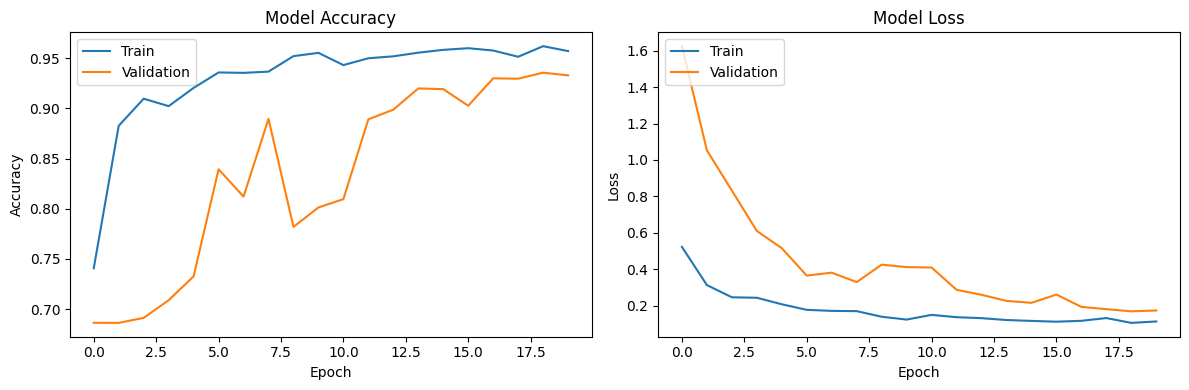

In [14]:
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


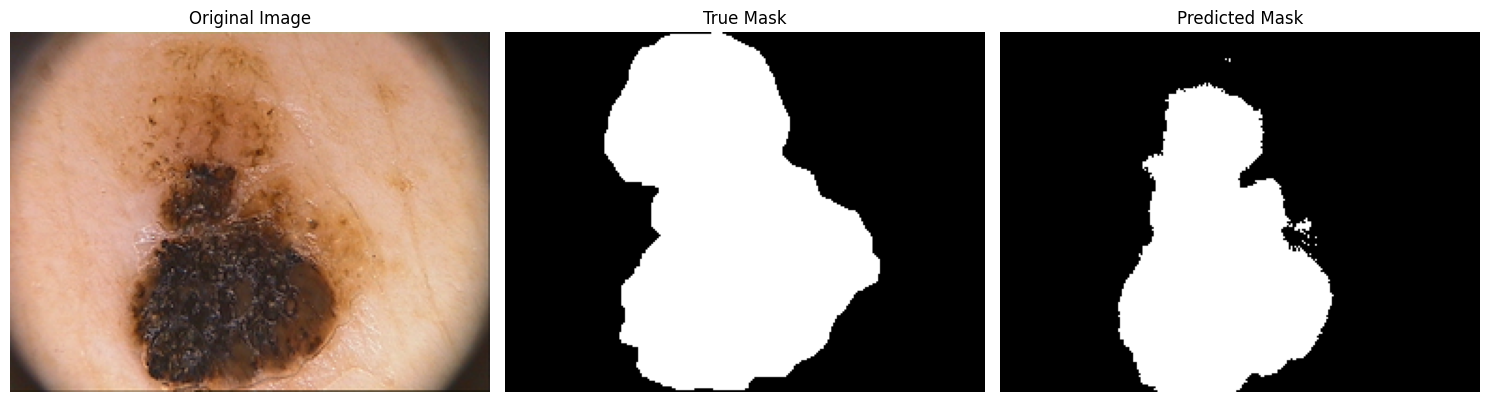

In [15]:
import random

# Select a random index from the test set
test_index = random.randint(0, len(x_test) - 1)

# Get the original image and true mask
original_image = x_test[test_index]
true_mask = y_test[test_index]

# The model expects a batch of images, so expand dimensions for a single image
input_image_for_prediction = np.expand_dims(original_image, axis=0)

# Make a prediction with the U-Net model
predicted_mask = unet.predict(input_image_for_prediction)

# Squeeze the batch dimension and apply a threshold to get a binary mask for visualization
predicted_mask = np.squeeze(predicted_mask, axis=0) # Remove batch dimension
predicted_mask_binary = (predicted_mask > 0.5).astype(np.float32) # Apply threshold (0.5 is common for sigmoid output)

# Squeeze the channel dimension for true_mask if it has one (y_test was expanded earlier)
true_mask_display = np.squeeze(true_mask, axis=-1)
predicted_mask_display = np.squeeze(predicted_mask_binary, axis=-1)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(original_image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(true_mask_display, cmap='gray')
plt.title('True Mask')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(predicted_mask_display, cmap='gray')
plt.title('Predicted Mask')
plt.axis('off')

plt.tight_layout()
plt.show()

In [16]:
from sklearn.metrics import classification_report

# Flatten the true masks and predicted masks for the entire test set
true_masks_flat = y_test.flatten().astype(int)

# Generate predictions for the entire test set
# The model output is a probability map, so we need to apply a threshold
predicted_masks_raw = unet.predict(x_test)
predicted_masks_binary_flat = (predicted_masks_raw > 0.5).flatten().astype(int)

# Generate the classification report
report = classification_report(
    true_masks_flat,
    predicted_masks_binary_flat,
    target_names=['Background', 'Foreground']
)

print("Classification Report for Test Set:\n")
print(report)

2/2 ━━━━━━━━━━━━━━━━━━━━ 65s 26s/step
Classification Report for Test Set:

              precision    recall  f1-score   support

  Background       0.93      0.98      0.95   1686574
  Foreground       0.95      0.83      0.89    771026

    accuracy                           0.93   2457600
   macro avg       0.94      0.91      0.92   2457600
weighted avg       0.93      0.93      0.93   2457600



## Define SegNet Architecture

### Subtask:
Generate the Python code to define the SegNet model architecture using Keras/TensorFlow layers, including the encoder, decoder, and specialized unpooling layers.


#### Reasoning:
To define the SegNet architecture, I will create a Python code block. SegNet typically uses a specialized unpooling layer that utilizes the indices generated during max-pooling to perform upsampling. However, standard Keras's `UpSampling2D` layer does not take pooling indices as input. For the purpose of this implementation with standard Keras layers, I will use `UpSampling2D` as a simpler alternative to represent the upsampling part of the decoder. The model will consist of an encoder pathway with convolutional blocks and max-pooling, a bottleneck, and a decoder pathway with `UpSampling2D` and convolutional blocks. Finally, a sigmoid activation will be used for the output layer for binary segmentation.

**Reasoning**:
Based on the instructions and the SegNet architecture, I will define the `segnet_model` function including the encoder, decoder with `UpSampling2D` layers, and a final sigmoid activated convolutional layer. Then, I will instantiate the model and print its summary.



**✅ Key idea**

SegNet does NOT use skip connections.
Instead, it stores max-pooling indices and uses them during upsampling.

**✅ Architecture**

* Encoder (VGG-style)

* Decoder

* Upsampling via pooling indices

* No feature concatenation

**✅ Strengths**

* Lower memory usage

* Faster inference

* Cleaner architecture

**❌ Weaknesses**

* Less accurate edges

* Loses fine spatial details

* Needs larger datasets to perform well

In [17]:
from keras.layers import concatenate, UpSampling2D # concatenate is not used in this SegNet implementation but was previously imported

# Reusing the conv_block defined earlier for consistency
def conv_block(input_tensor, num_filters):
    encoder = Conv2D(num_filters, (3, 3), padding='same')(input_tensor)
    encoder = BatchNormalization()(encoder)
    encoder = Activation('relu')(encoder)
    encoder = Conv2D(num_filters, (3, 3), padding='same')(encoder)
    encoder = BatchNormalization()(encoder)
    encoder = Activation('relu')(encoder)
    return encoder

def segnet_model(input_size=(192, 256, 3)):
    inputs = Input(input_size)

    # Encoder Path
    # Block 1
    conv1 = conv_block(inputs, 64)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) # Output: (96, 128, 64)

    # Block 2
    conv2 = conv_block(pool1, 128)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) # Output: (48, 64, 128)

    # Block 3
    conv3 = conv_block(pool2, 256)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3) # Output: (24, 32, 256)

    # Block 4 (Bottleneck equivalent in SegNet structure)
    conv4 = conv_block(pool3, 512)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4) # Output: (12, 16, 512)

    # Decoder Path
    # Decoder Block 1 (Upsample to match pool4's spatial dim, then convolve)
    up1 = UpSampling2D(size=(2, 2))(pool4) # Output: (24, 32, 512)
    deconv1 = conv_block(up1, 512) # Output: (24, 32, 512)

    # Decoder Block 2
    up2 = UpSampling2D(size=(2, 2))(deconv1) # Output: (48, 64, 512)
    deconv2 = conv_block(up2, 256) # Output: (48, 64, 256)

    # Decoder Block 3
    up3 = UpSampling2D(size=(2, 2))(deconv2) # Output: (96, 128, 256)
    deconv3 = conv_block(up3, 128) # Output: (96, 128, 128)

    # Decoder Block 4
    up4 = UpSampling2D(size=(2, 2))(deconv3) # Output: (192, 256, 128)
    deconv4 = conv_block(up4, 64) # Output: (192, 256, 64)

    # Output layer for binary segmentation
    outputs = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(deconv4) # Output: (192, 256, 1)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model

# Instantiate the SegNet model
segnet = segnet_model()
segnet.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 192, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 192, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 192, 256, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_18 (Activation)      │ (None, 192, 256, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 192, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 192, 256, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_19 (Activation)      │ (None, 192, 256, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 96, 128, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 96, 128, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 96, 128, 128)   │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_20 (Activation)      │ (None, 96, 128, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 96, 128, 128)   │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 96, 128, 128)   │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_21 (Activation)      │ (None, 96, 128, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 48, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 48, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 48, 64, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_22 (Activation)      │ (None, 48, 64, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 48, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 48, 64, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_23 (Activation)      │ (None, 48, 64, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 24, 32, 256)    │             

 Total params: 11,743,745 (44.80 MB)

 Trainable params: 11,736,065 (44.77 MB)

 Non-trainable params: 7,680 (30.00 KB)

**Reasoning**:
The next step is to compile the newly defined SegNet model. I will use the Adam optimizer with a learning rate of 1e-4, 'binary_crossentropy' as the loss function, and 'accuracy' as a metric, consistent with the U-Net compilation.



In [18]:
segnet.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
print("SegNet model compiled successfully with Adam optimizer, binary crossentropy loss, and accuracy metric.")

SegNet model compiled successfully with Adam optimizer, binary crossentropy loss, and accuracy metric.


## Train the SegNet Model

### Subtask:
Train the `segnet` model using `x_train`, `y_train` as training data and `x_test`, `y_test` as validation data for 20 epochs with a batch size of 16, storing the training history in the `history_segnet` variable.


**Reasoning**:
I will train the `segnet` model using the specified training and validation data, epochs, and batch size, storing the training history in the `history_segnet` variable as instructed.



In [19]:
history_segnet = segnet.fit(
    x_train,
    y_train,
    epochs=20,
    batch_size=16,
    validation_data=(x_test, y_test),
    verbose=1
)

print("SegNet model training complete. History stored in 'history_segnet' variable.")

Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.6922 - loss: 0.5731 - val_accuracy: 0.3185 - val_loss: 0.7836
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 18s 558ms/step - accuracy: 0.9112 - loss: 0.2627 - val_accuracy: 0.3285 - val_loss: 1.2904
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 567ms/step - accuracy: 0.8993 - loss: 0.2630 - val_accuracy: 0.3579 - val_loss: 0.9732
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 577ms/step - accuracy: 0.9310 - loss: 0.1948 - val_accuracy: 0.3769 - val_loss: 1.0735
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 579ms/step - accuracy: 0.9266 - loss: 0.1983 - val_accuracy: 0.6182 - val_loss: 0.6543
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 589ms/step - accuracy: 0.9262 - loss: 0.2003 - val_accuracy: 0.6597 - val_loss: 0.6235
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 576ms/step - accuracy: 0.9361 - loss: 0.1768 - val_accuracy: 0.7338 - val_loss: 0.5577
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 566ms/step - accuracy: 0.9396 - loss: 0.1629 - val_accuracy: 0.7

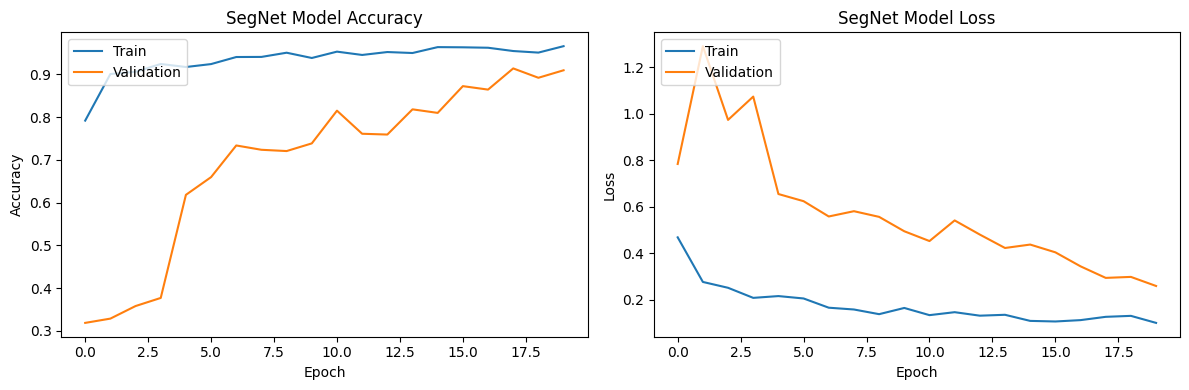

In [21]:
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history_segnet.history['accuracy'])
plt.plot(history_segnet.history['val_accuracy'])
plt.title('SegNet Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_segnet.history['loss'])
plt.plot(history_segnet.history['val_loss'])
plt.title('SegNet Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


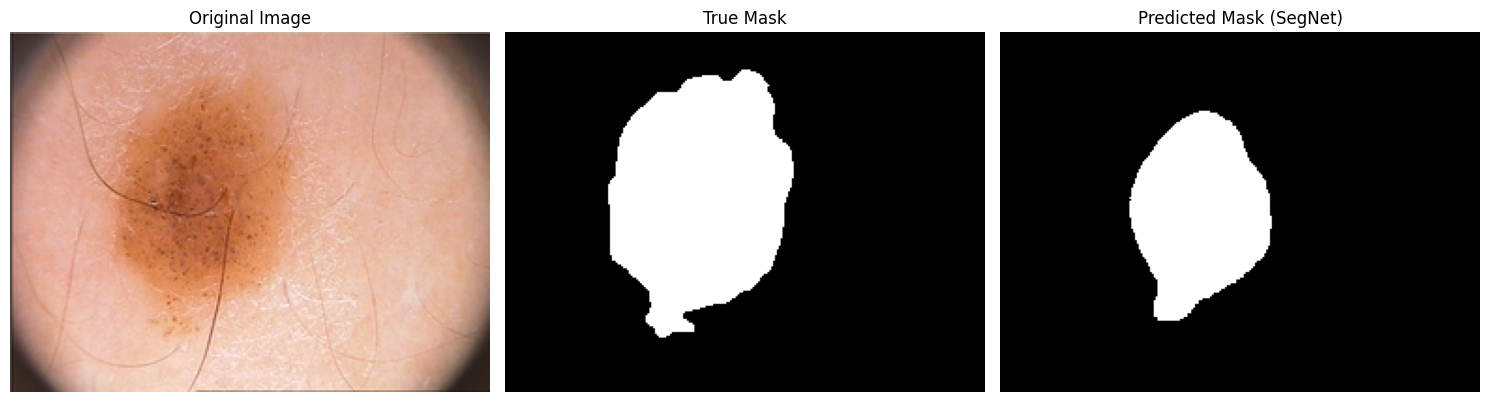

In [20]:
import random

# Select a random index from the test set
test_index = random.randint(0, len(x_test) - 1)

# Get the original image and true mask
original_image = x_test[test_index]
true_mask = y_test[test_index]

# The model expects a batch of images, so expand dimensions for a single image
input_image_for_prediction = np.expand_dims(original_image, axis=0)

# Make a prediction with the SegNet model
predicted_mask = segnet.predict(input_image_for_prediction)

# Squeeze the batch dimension and apply a threshold to get a binary mask for visualization
predicted_mask = np.squeeze(predicted_mask, axis=0) # Remove batch dimension
predicted_mask_binary = (predicted_mask > 0.5).astype(np.float32) # Apply threshold (0.5 is common for sigmoid output)

# Squeeze the channel dimension for true_mask if it has one (y_test was expanded earlier)
true_mask_display = np.squeeze(true_mask, axis=-1)
predicted_mask_display = np.squeeze(predicted_mask_binary, axis=-1)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(original_image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(true_mask_display, cmap='gray')
plt.title('True Mask')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(predicted_mask_display, cmap='gray')
plt.title('Predicted Mask (SegNet)')
plt.axis('off')

plt.tight_layout()
plt.show()

In [22]:
from sklearn.metrics import classification_report

# Flatten the true masks and predicted masks for the entire test set
true_masks_flat = y_test.flatten().astype(int)

# Generate predictions for the entire test set with SegNet
# The model output is a probability map, so we need to apply a threshold
predicted_masks_raw_segnet = segnet.predict(x_test)
predicted_masks_binary_flat_segnet = (predicted_masks_raw_segnet > 0.5).flatten().astype(int)

# Generate the classification report for SegNet
report_segnet = classification_report(
    true_masks_flat,
    predicted_masks_binary_flat_segnet,
    target_names=['Background', 'Foreground']
)

print("Classification Report for SegNet Test Set:\n")
print(report_segnet)

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 968ms/step
Classification Report for SegNet Test Set:

              precision    recall  f1-score   support

  Background       0.90      0.98      0.94   1686574
  Foreground       0.95      0.75      0.84    771026

    accuracy                           0.91   2457600
   macro avg       0.92      0.87      0.89   2457600
weighted avg       0.91      0.91      0.91   2457600

